In [6]:
options(tidyverse.quiet = TRUE) 
library(tidyverse, warn.conflicts = FALSE)

library(badr)
load_julia_package()

Loaded julia package 'bad' successfully.



# Introduction

## Inefficiency of the standard Binomial test

The first part of this notebook explores the inefficiency of the fixed-size binomial test. 
A graph plotting the power and type one error rate on the boundary of the null hypothesis is produced and the standard binomial test is compared to the optimal randomised test.


In [16]:
alpha <- .05 # maximal type one error rate
beta  <- .2  # maximal type two error rate
p0    <- .2  # boundary of the null hypothesis H0: p <= p0
p1    <- .4  # point alternative to power on

Start by finding the minimal sample size and the corresponding critical value of a standard binomial test for the given parameters.

In [21]:
binomial_test(alpha, beta, p0, p1) %>% {nn <<- .$n; cc <<- .$c}

tibble(`sample size` = nn, `critical value` = cc)

sample size,critical value
<int>,<int>
35,11


Define a function to compute the power of the optimal randomised test, the randomisation probability of the final decision is chosen such that the maximal type one error rate is fully exhausted.

In [22]:
randomise_binomial_power <- function(n, c, alpha, p0, p1) {
    toer              <- 1 - pbinom(c, size = n, prob = p0)
    rej_prob_boundary <-  (alpha - toer) / dbinom(c, size = n, prob = p0)
    power             <- 1 - pbinom(c, size = n, prob = p1) + rej_prob_boundary*dbinom(c, size = n, prob = p1)
    return(power)
}

Generate the plotting data.

In [25]:
tbl_plot <- tibble(
        n     = seq(nn - 10, nn + 10),
        c     = map_int(n, ~tail(which((1 - pbinom(seq(0, .), size = ., prob = p0) ) > alpha), 1)),
        power = 1 - pbinom(c, size = n, prob = p1),
        `maximal type one error rate`  = 1 - pbinom(c, size = n, prob = p0),
        `power, randomised` = randomise_binomial_power(n, c, alpha, p0, p1)
    ) %>%
    pivot_longer(-c(n, c))

print(tbl_plot, n = 10)

# A tibble: 63 x 4
       n     c name                         value
   <int> <int> <chr>                        <dbl>
 1    25     8 power                       0.726 
 2    25     8 maximal type one error rate 0.0468
 3    25     8 power, randomised           0.733 
 4    26     9 power                       0.636 
 5    26     9 maximal type one error rate 0.0232
 6    26     9 power, randomised           0.739 
 7    27     9 power                       0.691 
 8    27     9 maximal type one error rate 0.0304
 9    27     9 power, randomised           0.748 
10    28     9 power                       0.741 
# … with 53 more rows


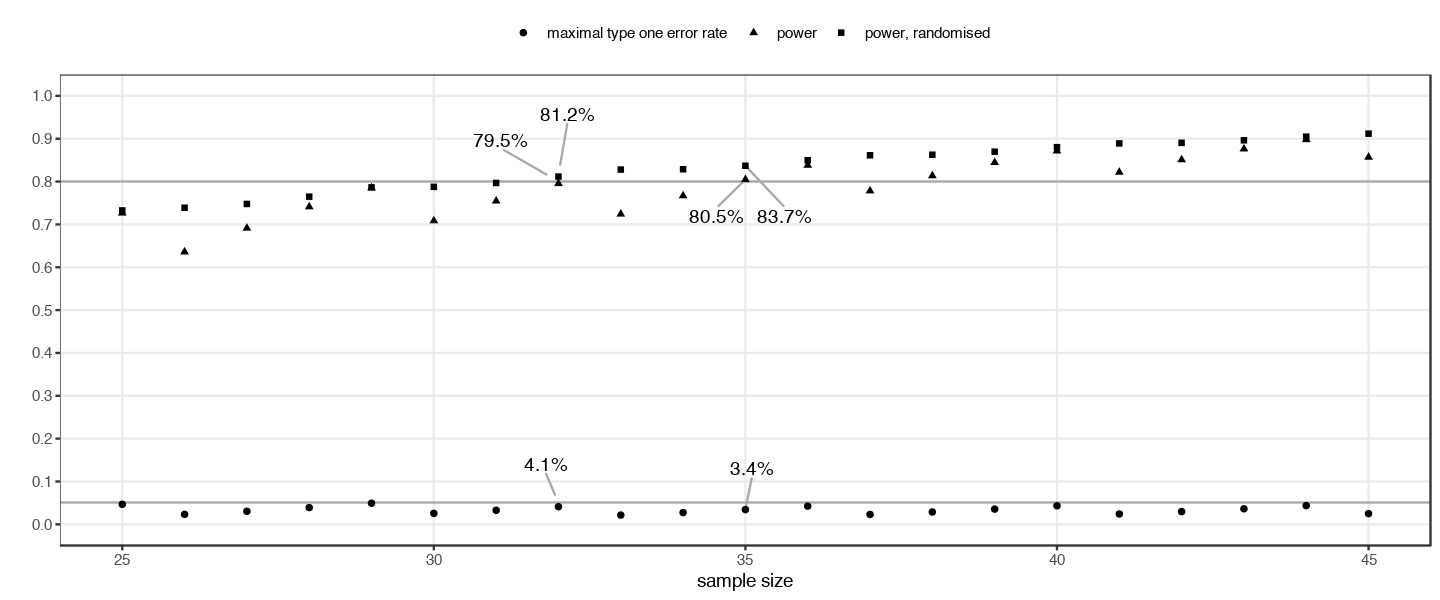

In [26]:
# plot
options(repr.plot.width = 12, repr.plot.height = 5)

ggplot(tbl_plot) +
    aes(n, value, shape = name) +
    geom_hline(yintercept = c(alpha, 1 - beta), color = 'darkgray') +
    ggrepel::geom_text_repel(
        aes(label = label),
        ylim = c(alpha + .05, 1 - beta - .05), nudge_x = .1, nudge_y = -.075,
        segment.color = 'darkgray',
        data = filter(tbl_plot, n == nn) %>%
            mutate(
                label = sprintf("%.1f%%", 100*value)
            )
    ) +
    ggrepel::geom_text_repel(
        aes(label = label),
        ylim = c(alpha, 1 - beta + .2), nudge_x = -.2, nudge_y = +.1,
        point.padding = 1,
        segment.color = 'darkgray',
        data = filter(tbl_plot, n == 32) %>%
            mutate(
                label = sprintf("%.1f%%", 100*value)
            )
    ) +
    geom_point() +
    scale_shape('') +
    scale_x_continuous('sample size') +
    scale_y_continuous('', limits = c(0, 1), breaks = seq(0, 1, .1)) +
    theme_bw() +
    theme(
        legend.position  = 'top',
        legend.direction = 'horizontal',
        panel.grid.minor = element_blank()
    )

In [27]:
# save plot as .pdf
ggsave("introduction-binomial-power.pdf", width = 7, height = 4)

## Compare the fixed Binomial test with Simon's design

use the badr package to quickly plot a comparison between a classic two-stage design (Simon's design) and the fixed-size binomial plot.

In [29]:
design_binomial <- Design(
    rep(0, nn + 1),
    c(rep(Inf, cc + 1), rep(-Inf, nn - cc)),
    label = 'binomial'
)

design_binomial

An object of class "Design"
Slot "jdesign":
Julia Object of type Design.
Design<n=35;c=11>
Slot "label":
[1] "binomial"


In [30]:
design_simon <- Design(
    c(rep(0, 4), rep(30, 10)),
    c(rep(Inf, 4), rep(12, 10) - seq(4, 13)),
    label = "Simon's"
)

design_simon

An object of class "Design"
Slot "jdesign":
Julia Object of type Design.
Design<n1=13;n2:[4,13]->30>
Slot "label":
[1] "Simon's"


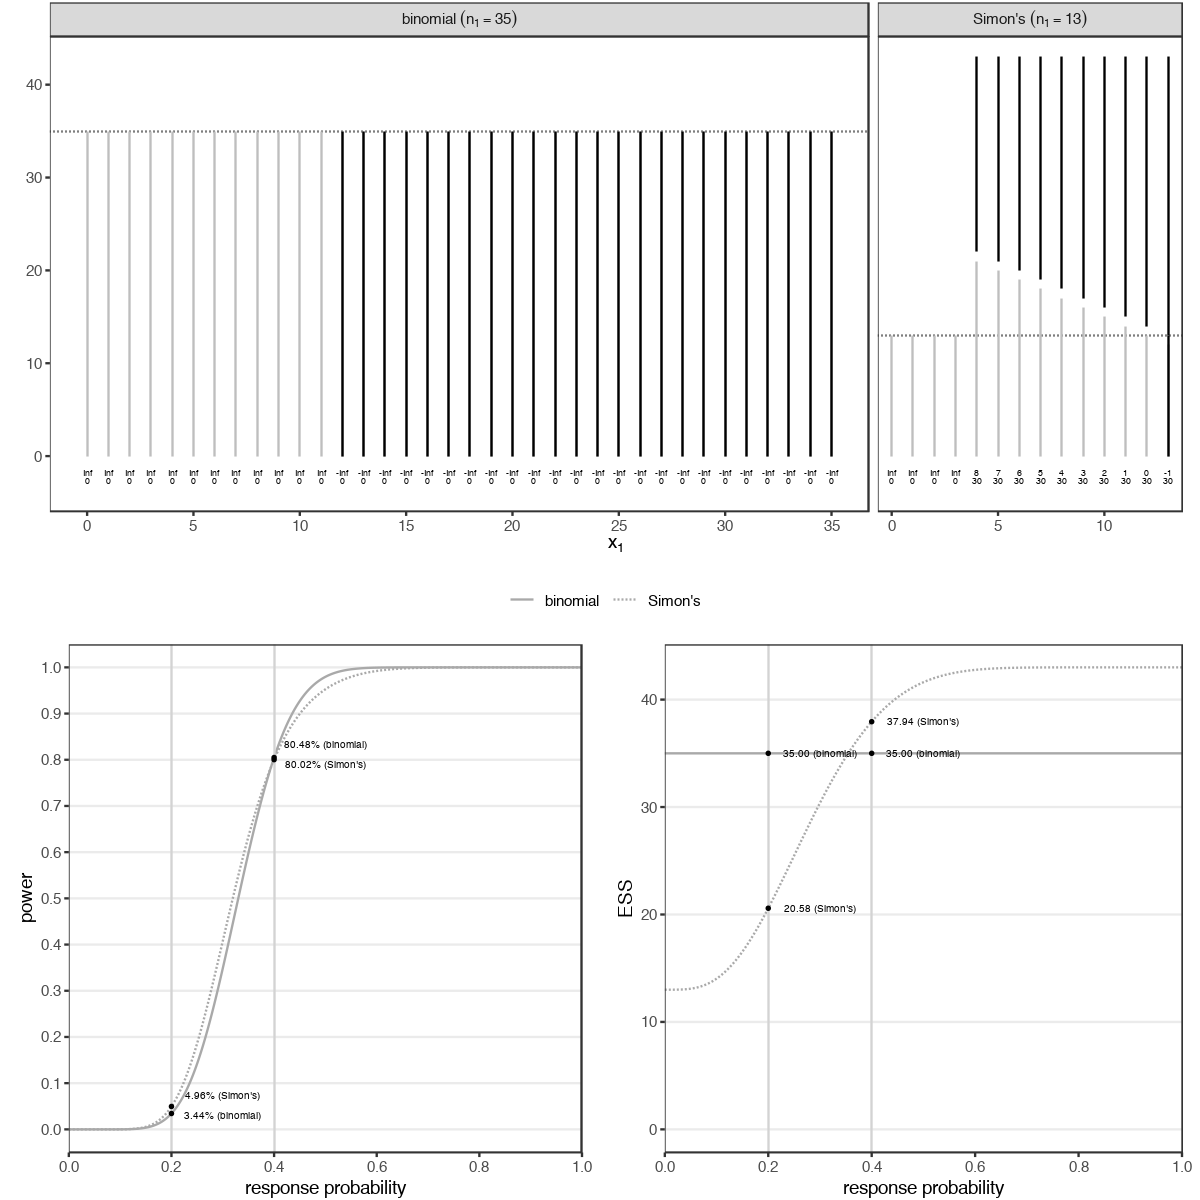

In [36]:
# use standard plot to compare
options(repr.plot.width = 12, repr.plot.height = 10)

plot_compare_designs(design_binomial, design_simon, annotations = c(p0, p1))

In [37]:
# save plot as .pdf
ggsave("introduction-binomial-vs-simons.pdf", width = 7, height = 7)

## Adaptive sample size re-calculation

Finally, an adaptive sample size re-calculation based on conditional power is compared with both previous designs.
To make things easier to compare, the re-calculation is conducted at exactly the same time as the interim analysis of Simon's design.
The fixed binomial test can also be interpreted as a two-stage design with no adaptation at the interim analysis.

In [40]:
# get stage one sample size of Simon's design
n1 <- sample_size(design_simon) 

In [42]:
design_binomial2 <- Design(
    rep(nn - n1, n1 + 1),
    cc - 0:n1,
    label = 'binomial'
)

design_binomial2

An object of class "Design"
Slot "jdesign":
Julia Object of type Design.
Design<n1=13;n2:[0,13]->22>
Slot "label":
[1] "binomial"


Define the recalculation rule such that the sample size is increased when the conditional power, $Pr[X_2>c_2(x_1)]$ is smaller than the target 80\%. 
The maximal increase is 70.

In [44]:
# define recalculation rule
recalculate <- function(n2old, c2old, beta, p0, p1, n2max = 70 - n1) {
    ce_old <- 1 - pbinom(c2old, n2old, p0)
    n2     <- n2old
    c2     <- c2old
    cpower <- 1 - pbinom(c2, n2, p1)
    if (cpower >= 1) {
        return(list(n2 = 0, c2 = -Inf))
    }
    if (cpower <= 0) {
        return(list(n2 = 0, c2 = Inf))
    }
    if (cpower >= 1 - beta) {
        return(list(n2 = n2, c2 = c2))
    }
    c2_of_n2 <- function(n2) {
        candidates <- which((1 - pbinom(0:n2, size = n2, prob = p0) ) > ce_old)
        ifelse(length(candidates) == 0, n2, tail(candidates, 1))
    }
    while (cpower < 1 - beta & n2 <= n2max) {
        n2     <- n2 + 1
        c2     <- c2_of_n2(n2)
        cpower <- 1 - pbinom(c2, n2, p1)
        cerr   <- 1 - pbinom(c2, n2, p0)
    }
    return(list(n2 = n2, c2 = c2))
}

In [46]:
design_recalculated <- tibble(
        x1   = 0:n1,
        data = map(x1, ~as_tibble(recalculate(nn - n1, cc - ., .2, .2, .4)))
    ) %>%
    unnest(data) %>%
    {Design(.$n2, .$c2, label = 'recalculation')}

design_recalculated

An object of class "Design"
Slot "jdesign":
Julia Object of type Design.
Design<n1=13;n2:[0,11]->[22,58]>
Slot "label":
[1] "recalculation"


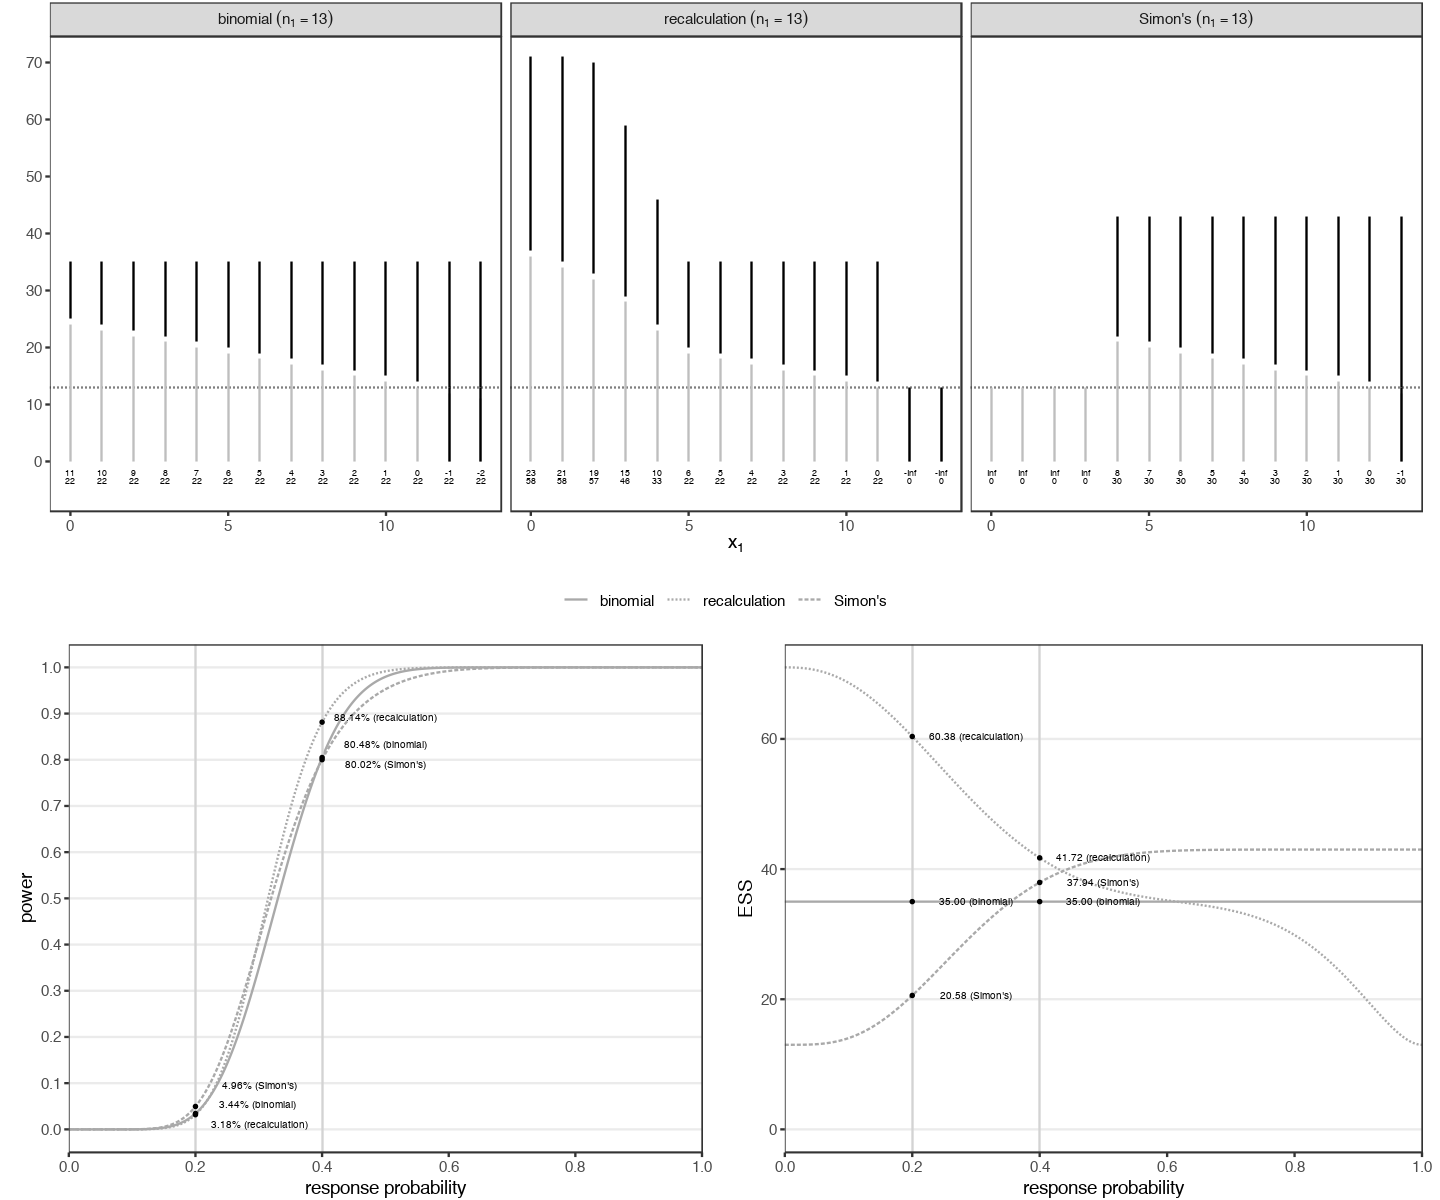

In [50]:
# use standard plot to compare
options(repr.plot.width = 12, repr.plot.height = 10)

plot_compare_designs(
    design_binomial2, design_simon, design_recalculated,
    annotations = c(p0, p1)
)

In [51]:
# save to .pdf
ggsave("introduction-sample-size-recalculation.pdf", width = 7, height = 7)

To visualise the impact of the re-calculation, the conditional power for all three designs and all possible interim outcomes is plotted.

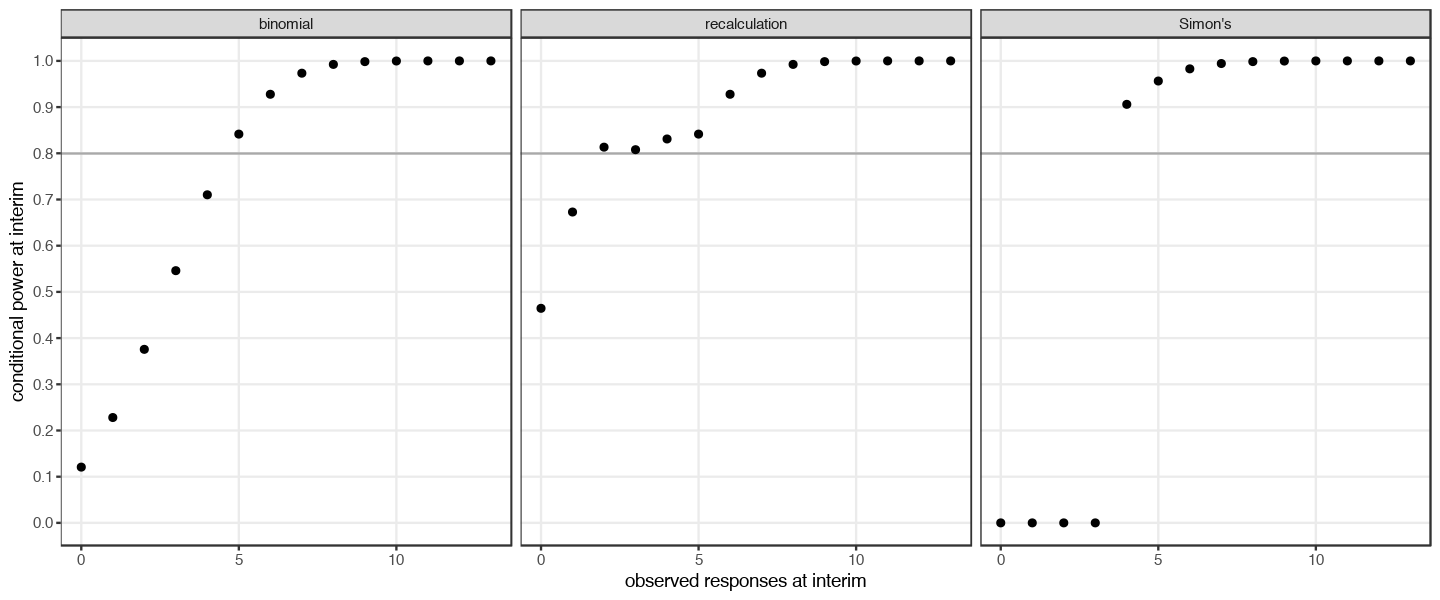

In [56]:
options(repr.plot.width = 12, repr.plot.height = 5)

tibble(
        design      = list(design_binomial2, design_simon, design_recalculated),
        design_name = map_chr(design, ~.@label),
        data        = map(design, function(d)
                tibble(
                    x1 = 0:sample_size(d),
                    cp = map_dbl(x1, ~(1 - pbinom(critical_value(d, .), sample_size(d, .) - sample_size(d), p1)))
                )
            )
    ) %>%
    unnest(data) %>%
    ggplot() +
        aes(x1, cp) +
        geom_hline(yintercept = 1 - beta, color = 'darkgray') +
        geom_point() +
        scale_x_continuous("observed responses at interim") +
        scale_y_continuous("conditional power at interim", breaks = seq(0, 1, .1)) +
        facet_wrap(~design_name) +
        theme_bw() +
        theme(
            panel.grid.minor = element_blank()
        )

In [59]:
# save .pdf
ggsave("introduction-sample-size-recalculation-conditional-power.pdf", width = 7, height = 3)